## Problem Statement: Bank Churn Prediction

-------------------------------------------------------------------------------------------------------------------------

### Objective:

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not.

Context:

Businesses like banks which provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

Data Description:

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance etc. Link to the Kaggle project site: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

#### 1.- Read the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette="Set2")
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf     # Import Tensorflow to create the Neural Network model
print(tf.__version__)
import random as rn
tf.random.set_seed(33)
np.random.seed(33)
rn.seed(33)

2.0.0


In [2]:
df = pd.read_csv('bank.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### 2.- Drop the columns which are unique for all users like IDs (5points)
    

'RowNumber' is just a sequencial numbering of the sample, and 'CustomerID' is a number assigned by the bank arbitrarily, so those need to be dropped 

'Surename' could not have any correlation with the probability of the customer to leave the bank, hence a candidate to be dropped, as it could not add to the prediction (unless a whole family is disgrouted with the bank service), but also would create a high number of dummy variables that could make the Neural Network processing svery lower. I'm deciding to drop it.

The output variable is 'Exited', 1 means the customer exited the bank (churned), o means still a customer of the bank.


In [4]:
# Making copies of the database for use downstream
df2=df.copy(deep=True) 
df2=df2.drop(['RowNumber','CustomerId','Surname'],axis=1)# droping vatriables that are unique for all users
df3=df2.copy(deep=True)
df3=df3.drop(['Geography','Gender','Exited'],axis=1)# droping categorical and output variables for plotting


In [5]:
print("Shape: ",df2.shape) # to know the shape of the data
df.dtypes # - understand the data types
# There is a mix of numerical and categorical variables, some of which need to be one-hot encoded and scaled 

Shape:  (10000, 11)


RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
df2.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### 3.- Distinguish the features and target variable(5points)
    

AxesSubplot(0.125,0.125;0.775x0.755)


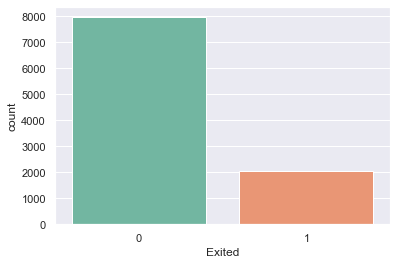

In [7]:
# The output variable is 'Exited', 1 means the customer exited the bank (churned), o means still a customer of the bank.
print(sns.countplot(df2['Exited']))

The data is imbalanced: 20% of the customers exited


#### I will perform regular EDA:
(Exploratory Data Analysis)

In [8]:
# look for null values:
df.isnull().sum().sum()

0

In [9]:
# No null values
df2.describe().transpose()   #obtaning mean, min, max, quantiles and standard deviation

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


There are variables  (Balance, Estimated Salary) that need to be scaled for the neural network to work properly

In [10]:
dupes = df.duplicated()
sum(dupes)
# There are no duplicated rows

0

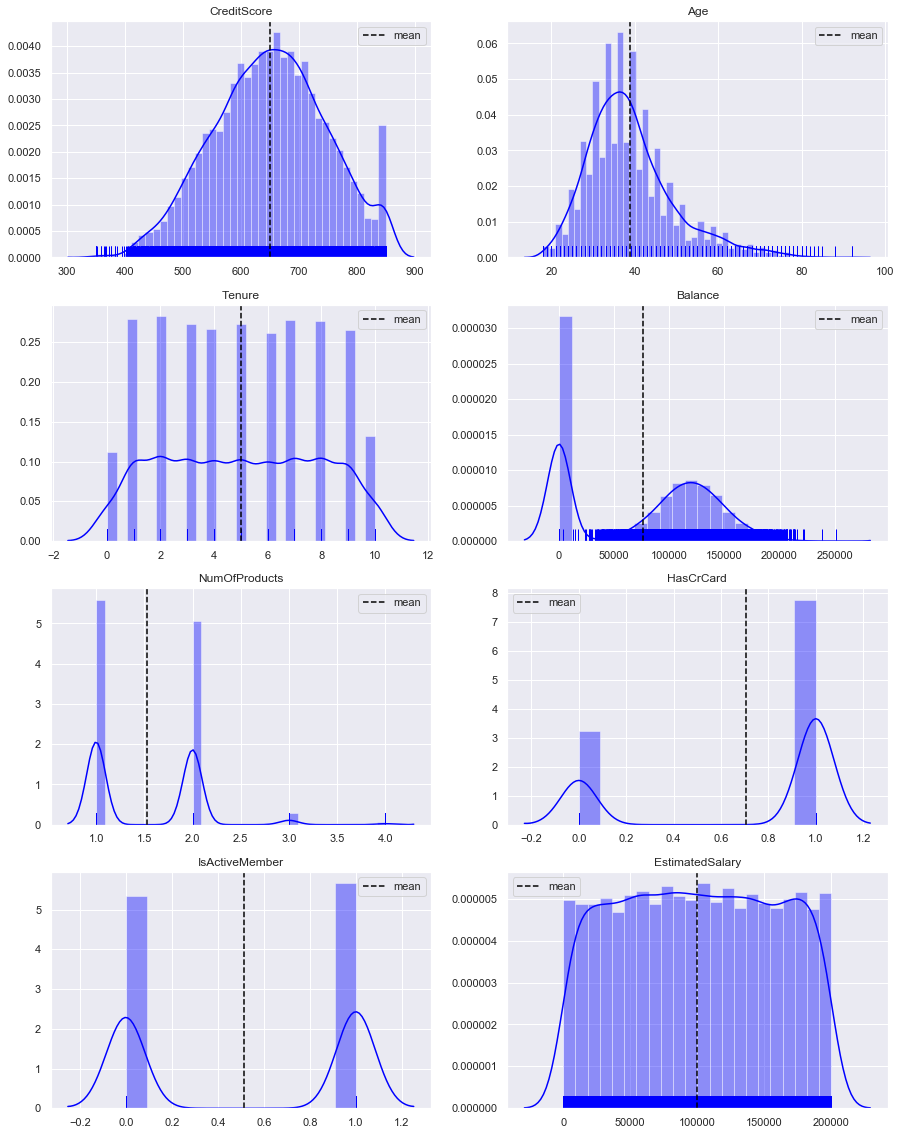

In [11]:
# Getting univariate plots to understand the distribution and bias of each variable
import itertools
cols = [i for i in df3.columns]
fig = plt.figure(figsize=(15, 20))
for i,j in itertools.zip_longest(cols, range(len(cols))):
    plt.subplot(4,2,j+1)
    ax = sns.distplot(df2[i],color='b',rug=True)
    plt.axvline(df2[i].mean(),linestyle="dashed",label="mean", color='black')
    plt.legend()
    plt.title(i)
    plt.xlabel("")

In [12]:
# there are several outliers in Age, Balance and HasCard , however I will not treat them as we will probably use scaling

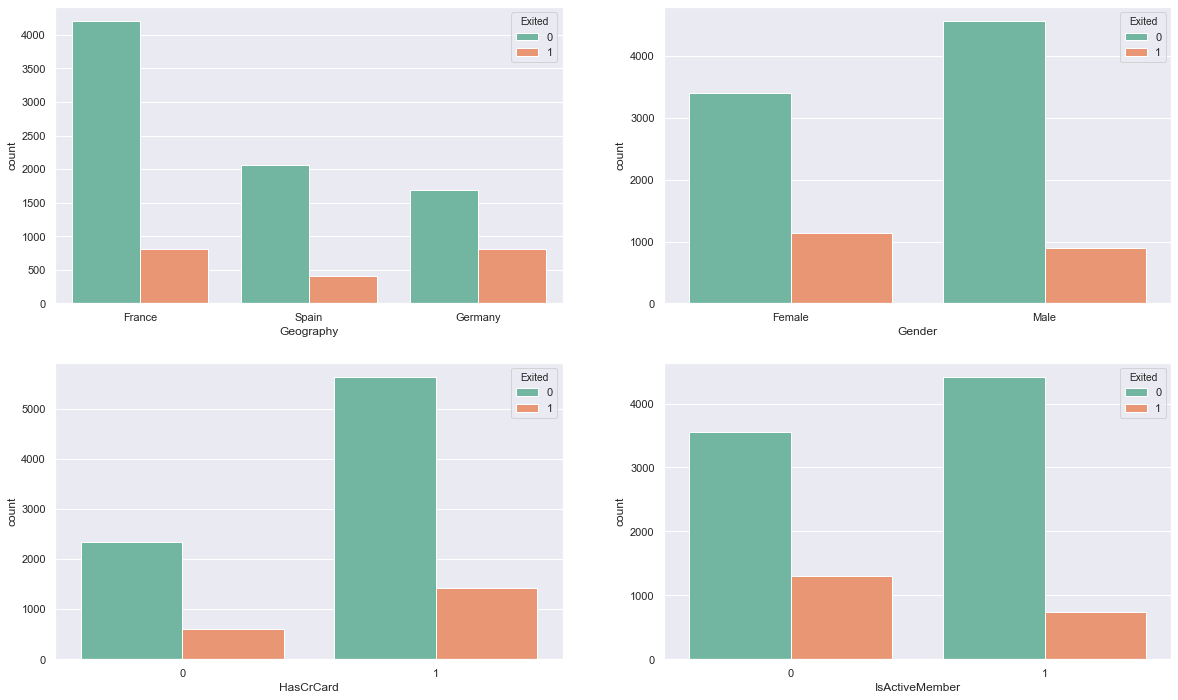

In [13]:
 # Review the 'Exited' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

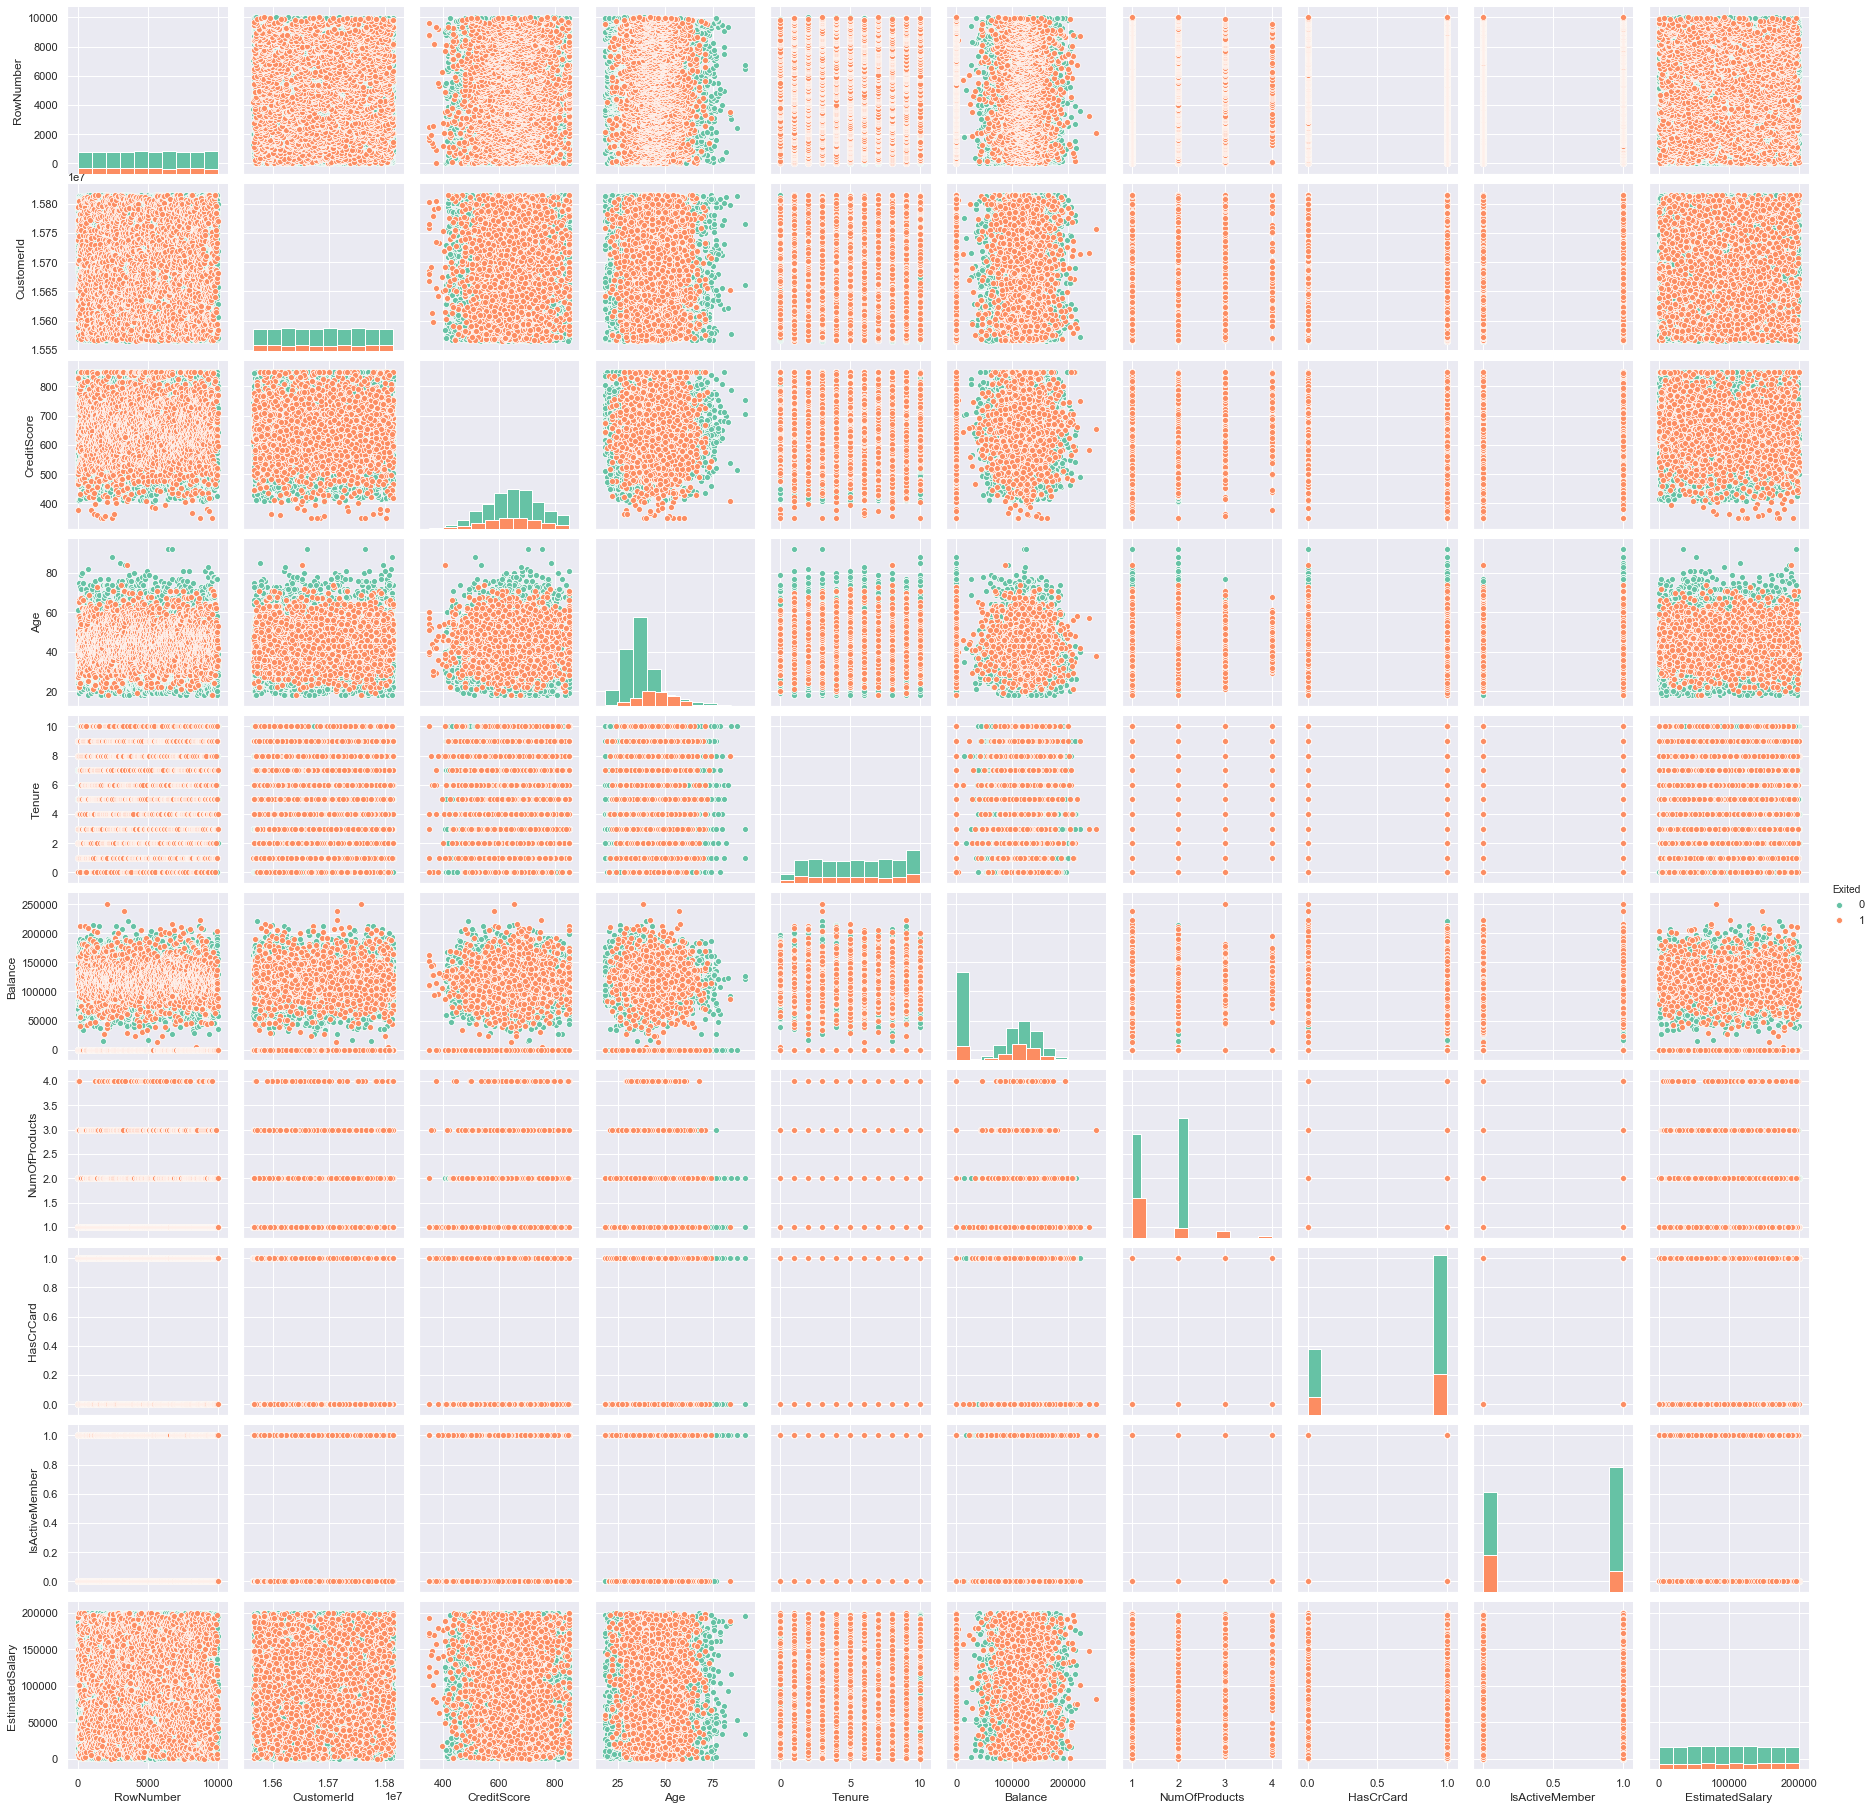

In [14]:
sns.pairplot(df,diag_kind='hist', hue='Exited')    
#  Pair-ploting the variables to see their relationship and visual grouping and correlation

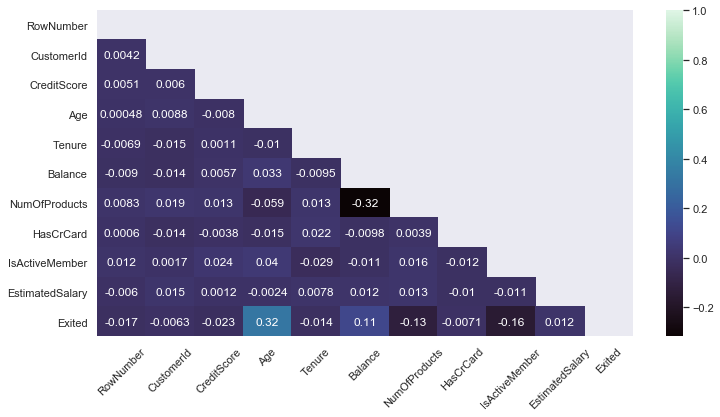

In [15]:
# Plotting correlations between the variables
plt.subplots(figsize=(12, 6))
corr = df.corr('spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(data=corr, cmap='mako', annot=True, mask=mask)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

No significant correlation between variables
only Age seems to have a moderate correlation with the output variable and Balance has a mild negative correlation with number of products, no action needed.

#### 4.- Divide the data set into training and test sets (5points)
    

In [16]:
df4=df2.copy(deep=True) # df4 will contain the data used in the analysis

In [17]:
from sklearn.model_selection import train_test_split
X = df4.iloc[:, :-1]
y = df4.iloc[:, -1]
X = pd.get_dummies(X, drop_first=True)   # creating the dummy variables for esch value of categorical variables 

# splitting data into training and test set for independent attributes
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=33)
print(X_train.shape, X_test.shape)

(7000, 11) (3000, 11)


#### 5.- Normalize the train and test data (10points)
    

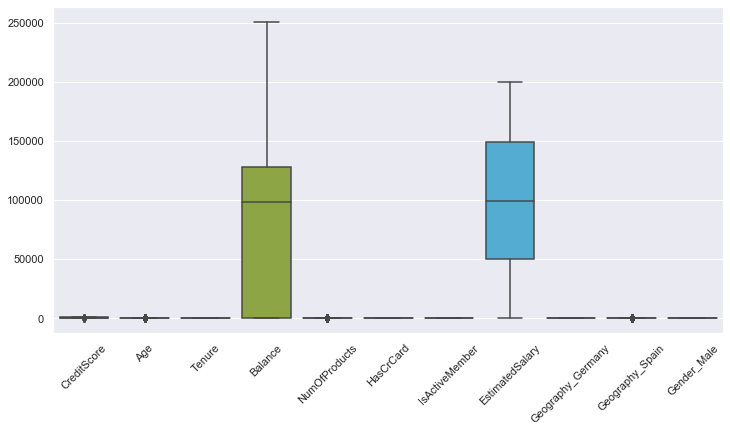

In [18]:
# doing box plot to see scale comparison and identify outliers:
plt.subplots(figsize=(12, 6))
ax = sns.boxplot(data=X_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

As saw during EDA, Balance and Estimated Salary need scaling
For that, I will try two types of normalization. I choose ZScore and also MinMax Scaling and run the models with both.

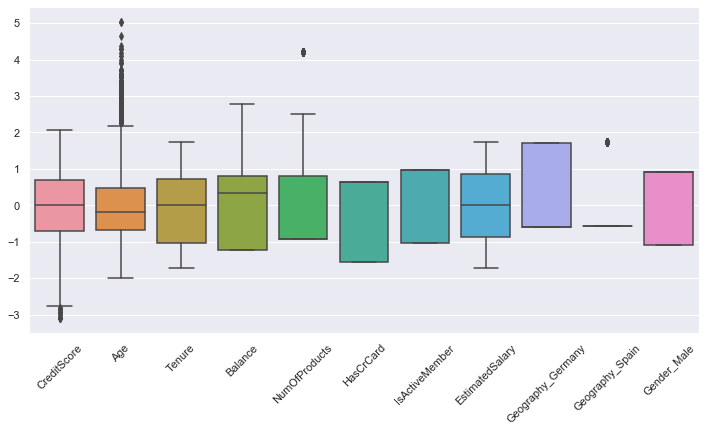

In [19]:
# normalizing database with Zscore:
from scipy.stats import zscore
XTrZ = X_train.apply(zscore)
XTeZ = X_test.apply(zscore)
# doing box plot to see scale, comparison and identify outliers:
plt.subplots(figsize=(12, 6))
ax = sns.boxplot(data=XTrZ)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

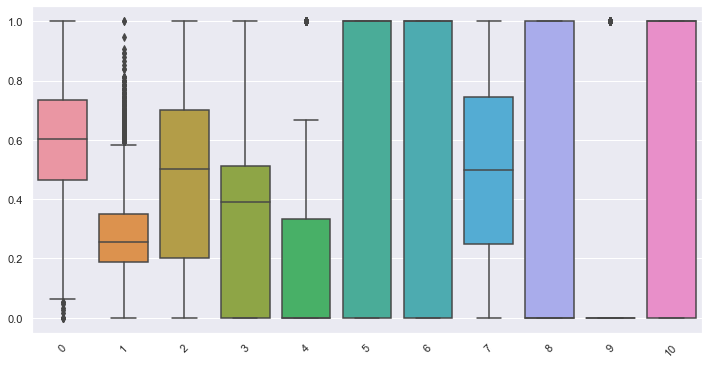

In [20]:
# normalizing database using minmax_scale
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale # Tried Normalize, MinMax
X_trainN = preprocessing.minmax_scale(X_train)
X_testN = preprocessing.minmax_scale(X_test)
# doing box plot to see scale, comparison and identify outliers:
plt.subplots(figsize=(12, 6))
ax = sns.boxplot(data=X_trainN)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Although there are some outliers, the features seem more even in both cases. The difference is that, in scaling, I'm changing the range the data while in normalization I'm changing the shape of the distribution of the data

#### 6.- Initialize & build the model. Identify the points of improvement and implement the same. Note that you need to demonstrate at least two models(the original and the improved one) and highlight the differences to complete this point. You can also demonstrate more models. (20points)
    

In [21]:
# Import additional libraries:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Recall, Accuracy
tf.keras.metrics.Recall(thresholds=None, top_k= None, class_id=None, name='recall', dtype=None)
from tensorflow.keras import optimizers
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score, )

In [22]:
# Normalizing using Zscore:
X_train1 = np.asarray(XTrZ)
y_train = np.asarray(y_train)
X_test1 = np.asarray(XTeZ)
y_test = np.asarray(y_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7000, 11)
(3000, 11)
(7000,)
(3000,)


In [23]:
# using the data from minmax_scaler to normalize:
X_train2 = np.asarray(X_trainN)
y_train = np.asarray(y_train)
X_test2 = np.asarray(X_testN)
y_test = np.asarray(y_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7000, 11)
(3000, 11)
(7000,)
(3000,)


I will create three diferent models and compare the results:
    - The first Model is small in number of layers and number of neurons per layer and using sigmoid activation function
    - Second Model is a large model  with reducing size of layers and using various types of activation functions
    - Third model is mid size, but using only tanh activation function

#### First Pass: Run the models using the data normalized with ZScore:
###### First Model   (small in layers and neurons per layer)

In [24]:
model = Sequential(layers=None, name=None) # creating new network with default plus two hiden layers:
model.add(Dense(10, input_shape = (11,), activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(1, activation = 'sigmoid'))

sgd = optimizers.Adam(lr = 0.025)# Set the optimizer and learning rate
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy', Recall()]) # Compile the model
model.fit(X_train1, y_train, batch_size = 7000, epochs = 500, verbose=1)   # Run the Network

results1= model.evaluate(X_train1, y_train, verbose=0) # create a results table:
results2 = model.evaluate(X_test1, y_test, verbose=0)
resultsDf = pd.DataFrame(   # create a results table:
    {'Model': ['Small model >'],'TrainAccuracy': results1[1], 'TrainRecall': results1[2],
     'TestAccuracy': results2[1], 'TestRecall': results2[2]})
resultsDf = resultsDf[['Model','TrainAccuracy','TrainRecall','TestAccuracy','TestRecall']]
resultsDf

Train on 7000 samples
Epoch 1/500
7000/7000 [==============================] - 1s 210us/sample - loss: 1.0111 - accuracy: 0.2071 - recall: 1.0000
Epoch 2/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.8618 - accuracy: 0.2071 - recall: 1.0000
Epoch 3/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.7422 - accuracy: 0.2071 - recall: 1.0000
Epoch 4/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.6520 - accuracy: 0.7929 - recall: 0.0000e+00
Epoch 5/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.5883 - accuracy: 0.7929 - recall: 0.0000e+00
Epoch 6/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.5467 - accuracy: 0.7929 - recall: 0.0000e+00
Epoch 7/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.5222 - accuracy: 0.7929 - recall: 0.0000e+00
Epoch 8/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.5101 - accuracy: 0.7929 -

Epoch 66/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.4658 - accuracy: 0.7929 - recall: 0.0000e+00
Epoch 67/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.4641 - accuracy: 0.7929 - recall: 0.0000e+00
Epoch 68/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.4623 - accuracy: 0.7929 - recall: 0.0000e+00
Epoch 69/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.4606 - accuracy: 0.7929 - recall: 0.0000e+00
Epoch 70/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.4588 - accuracy: 0.7929 - recall: 0.0000e+00
Epoch 71/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.4571 - accuracy: 0.7929 - recall: 0.0000e+00
Epoch 72/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.4553 - accuracy: 0.7929 - recall: 0.0000e+00
Epoch 73/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.4535 - accuracy: 0.7929 - rec

Epoch 132/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3824 - accuracy: 0.8441 - recall: 0.4034
Epoch 133/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3816 - accuracy: 0.8449 - recall: 0.4062
Epoch 134/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3808 - accuracy: 0.8453 - recall: 0.4069
Epoch 135/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3800 - accuracy: 0.8466 - recall: 0.4110
Epoch 136/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3791 - accuracy: 0.8477 - recall: 0.4152
Epoch 137/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3783 - accuracy: 0.8483 - recall: 0.4179
Epoch 138/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3774 - accuracy: 0.8499 - recall: 0.4228
Epoch 139/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3766 - accuracy: 0.8497 - recall: 0.4214
Epoch 14

7000/7000 [==============================] - 0s 3us/sample - loss: 0.3388 - accuracy: 0.8651 - recall: 0.5028
Epoch 199/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3384 - accuracy: 0.8659 - recall: 0.5041
Epoch 200/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3381 - accuracy: 0.8653 - recall: 0.5028
Epoch 201/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3378 - accuracy: 0.8654 - recall: 0.5034
Epoch 202/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3375 - accuracy: 0.8660 - recall: 0.5048
Epoch 203/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3372 - accuracy: 0.8664 - recall: 0.5048
Epoch 204/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3369 - accuracy: 0.8664 - recall: 0.5041
Epoch 205/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3367 - accuracy: 0.8661 - recall: 0.5055
Epoch 206/500
7000/700

Epoch 265/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3197 - accuracy: 0.8719 - recall: 0.5421
Epoch 266/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3195 - accuracy: 0.8720 - recall: 0.5434
Epoch 267/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3194 - accuracy: 0.8720 - recall: 0.5434
Epoch 268/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3192 - accuracy: 0.8721 - recall: 0.5434
Epoch 269/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3191 - accuracy: 0.8724 - recall: 0.5441
Epoch 270/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3189 - accuracy: 0.8724 - recall: 0.5434
Epoch 271/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3188 - accuracy: 0.8720 - recall: 0.5428
Epoch 272/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3187 - accuracy: 0.8729 - recall: 0.5448
Epoch 27

7000/7000 [==============================] - 0s 2us/sample - loss: 0.3142 - accuracy: 0.8743 - recall: 0.5434
Epoch 332/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3141 - accuracy: 0.8743 - recall: 0.5434
Epoch 333/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3141 - accuracy: 0.8743 - recall: 0.5421
Epoch 334/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3140 - accuracy: 0.8739 - recall: 0.5400
Epoch 335/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3139 - accuracy: 0.8734 - recall: 0.5400
Epoch 336/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3139 - accuracy: 0.8737 - recall: 0.5407
Epoch 337/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3138 - accuracy: 0.8736 - recall: 0.5400
Epoch 338/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3137 - accuracy: 0.8736 - recall: 0.5414
Epoch 339/500
7000/700

Epoch 398/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3104 - accuracy: 0.8730 - recall: 0.5407
Epoch 399/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3104 - accuracy: 0.8731 - recall: 0.5462
Epoch 400/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3104 - accuracy: 0.8733 - recall: 0.5414
Epoch 401/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3103 - accuracy: 0.8730 - recall: 0.5455
Epoch 402/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3103 - accuracy: 0.8736 - recall: 0.5414
Epoch 403/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3103 - accuracy: 0.8733 - recall: 0.5462
Epoch 404/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3102 - accuracy: 0.8734 - recall: 0.5421
Epoch 405/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3102 - accuracy: 0.8733 - recall: 0.5462
Epoch 40

7000/7000 [==============================] - 0s 2us/sample - loss: 0.3086 - accuracy: 0.8750 - recall: 0.5497
Epoch 465/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3086 - accuracy: 0.8749 - recall: 0.5441
Epoch 466/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3086 - accuracy: 0.8749 - recall: 0.5462
Epoch 467/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3086 - accuracy: 0.8750 - recall: 0.5483
Epoch 468/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3085 - accuracy: 0.8751 - recall: 0.5448
Epoch 469/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3085 - accuracy: 0.8753 - recall: 0.5503
Epoch 470/500
7000/7000 [==============================] - 0s 2us/sample - loss: 0.3085 - accuracy: 0.8751 - recall: 0.5448
Epoch 471/500
7000/7000 [==============================] - 0s 3us/sample - loss: 0.3085 - accuracy: 0.8747 - recall: 0.5476
Epoch 472/500
7000/700

,Model,TrainAccuracy,TrainRecall,TestAccuracy,TestRecall
0,Small model >,0.874714,0.546897,0.857,0.492334


This initial model reaches around .87 of Accuracy, but only around 0.5 of Recall for training data, which due to the imbalance nature of the Output data, is very small, is not a good result

##### Second Model (larger)

In [29]:
model = Sequential(layers=None, name=None) # In this model I use a combination of types of activation function layers
model.add(Dense(100, input_shape = (11,), activation = 'relu'))
model.add(Dense(75, activation = 'relu'))
model.add(Dense(60, activation = 'relu'))
model.add(Dense(40, activation = 'tanh'))
model.add(Dense(26, activation = 'elu'))
model.add(Dense(17, activation = 'relu'))
model.add(Dense(11, activation = 'exponential'))
model.add(Dense(7, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

sgd = optimizers.Adamax(lr = 0.025) # using Adamax as gave sligh better results with mixed types of activation functions
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy', Recall()])
model.fit(X_train1, y_train, batch_size = 7000, epochs = 500, verbose = 1)

results1= model.evaluate(X_train1, y_train, verbose=0)
results2 = model.evaluate(X_test1, y_test, verbose=0)
tempResultsDf = pd.DataFrame({'Model':['Larger  >'],
                          'TrainAccuracy': results1[1], 'TrainRecall': results1[2],
                          'TestAccuracy': results2[1], 'TestRecall': results2[2]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

Train on 7000 samples
Epoch 1/500
7000/7000 [==============================] - 2s 248us/sample - loss: 0.6195 - accuracy: 0.7929 - recall_1: 0.0000e+00
Epoch 2/500
7000/7000 [==============================] - 0s 11us/sample - loss: 1.4792 - accuracy: 0.7929 - recall_1: 0.0000e+00
Epoch 3/500
7000/7000 [==============================] - 0s 10us/sample - loss: 0.5185 - accuracy: 0.7929 - recall_1: 0.0000e+00
Epoch 4/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.5160 - accuracy: 0.7929 - recall_1: 0.0000e+00
Epoch 5/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.5126 - accuracy: 0.7929 - recall_1: 0.0000e+00
Epoch 6/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.4981 - accuracy: 0.7929 - recall_1: 0.0000e+00
Epoch 7/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.5020 - accuracy: 0.7929 - recall_1: 0.0000e+00
Epoch 8/500
7000/7000 [==============================] - 0s 12us/sample - 

Epoch 65/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3572 - accuracy: 0.8526 - recall_1: 0.4428
Epoch 66/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3571 - accuracy: 0.8607 - recall_1: 0.5821
Epoch 67/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3562 - accuracy: 0.8527 - recall_1: 0.4455
Epoch 68/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3538 - accuracy: 0.8621 - recall_1: 0.5683
Epoch 69/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3523 - accuracy: 0.8579 - recall_1: 0.5007
Epoch 70/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3511 - accuracy: 0.8631 - recall_1: 0.5476
Epoch 71/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3501 - accuracy: 0.8626 - recall_1: 0.5393
Epoch 72/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3492 - accuracy: 0.8617 - recall_1:

Epoch 130/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3179 - accuracy: 0.8754 - recall_1: 0.7834
Epoch 131/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3016 - accuracy: 0.8799 - recall_1: 0.6448
Epoch 132/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3077 - accuracy: 0.8741 - recall_1: 0.5752
Epoch 133/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3141 - accuracy: 0.8731 - recall_1: 0.7703
Epoch 134/500
7000/7000 [==============================] - 0s 12us/sample - loss: 0.3035 - accuracy: 0.8751 - recall_1: 0.5703
Epoch 135/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2959 - accuracy: 0.8821 - recall_1: 0.6476
Epoch 136/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2999 - accuracy: 0.8846 - recall_1: 0.7269
Epoch 137/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3163 - accuracy: 0.8649 - r

Epoch 195/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2954 - accuracy: 0.8744 - recall_1: 0.5400
Epoch 196/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2781 - accuracy: 0.8856 - recall_1: 0.8890
Epoch 197/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2517 - accuracy: 0.8981 - recall_1: 0.7497
Epoch 198/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2625 - accuracy: 0.8883 - recall_1: 0.6572
Epoch 199/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2717 - accuracy: 0.8896 - recall_1: 0.8848
Epoch 200/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2533 - accuracy: 0.8911 - recall_1: 0.6786
Epoch 201/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2457 - accuracy: 0.8983 - recall_1: 0.7228
Epoch 202/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2607 - accuracy: 0.8996 - r

Epoch 260/500
7000/7000 [==============================] - 0s 10us/sample - loss: 0.2317 - accuracy: 0.9080 - recall_1: 0.9441
Epoch 261/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2437 - accuracy: 0.8856 - recall_1: 0.6193
Epoch 262/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2233 - accuracy: 0.9129 - recall_1: 0.9455
Epoch 263/500
7000/7000 [==============================] - 0s 12us/sample - loss: 0.2066 - accuracy: 0.9149 - recall_1: 0.8483
Epoch 264/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2214 - accuracy: 0.9029 - recall_1: 0.7310
Epoch 265/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2126 - accuracy: 0.9160 - recall_1: 0.9283
Epoch 266/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.1962 - accuracy: 0.9174 - recall_1: 0.8345
Epoch 267/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2081 - accuracy: 0.9067 - r

Epoch 325/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.1863 - accuracy: 0.9239 - recall_1: 0.8628
Epoch 326/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2114 - accuracy: 0.9094 - recall_1: 0.7497
Epoch 327/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2882 - accuracy: 0.8480 - recall_1: 0.9945
Epoch 328/500
7000/7000 [==============================] - 0s 10us/sample - loss: 0.1846 - accuracy: 0.9187 - recall_1: 0.8883
Epoch 329/500
7000/7000 [==============================] - 0s 12us/sample - loss: 0.2673 - accuracy: 0.8907 - recall_1: 0.6331
Epoch 330/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.3309 - accuracy: 0.8121 - recall_1: 0.9966
Epoch 331/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2734 - accuracy: 0.8550 - recall_1: 0.9724
Epoch 332/500
7000/7000 [==============================] - 0s 10us/sample - loss: 0.3110 - accuracy: 0.8947 - r

Epoch 390/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2538 - accuracy: 0.8661 - recall_1: 0.9890
Epoch 391/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2157 - accuracy: 0.9091 - recall_1: 0.8772
Epoch 392/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2397 - accuracy: 0.9080 - recall_1: 0.7876
Epoch 393/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.1836 - accuracy: 0.9183 - recall_1: 0.9572
Epoch 394/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2097 - accuracy: 0.9021 - recall_1: 0.9710
Epoch 395/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.1898 - accuracy: 0.9169 - recall_1: 0.8834
Epoch 396/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.2014 - accuracy: 0.9117 - recall_1: 0.7697
Epoch 397/500
7000/7000 [==============================] - 0s 10us/sample - loss: 0.1745 - accuracy: 0.9263 - r

Epoch 455/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.1080 - accuracy: 0.9646 - recall_1: 0.9979
Epoch 456/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.1076 - accuracy: 0.9647 - recall_1: 0.9986
Epoch 457/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.1078 - accuracy: 0.9647 - recall_1: 0.9993
Epoch 458/500
7000/7000 [==============================] - 0s 10us/sample - loss: 0.1072 - accuracy: 0.9647 - recall_1: 0.9986
Epoch 459/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.1069 - accuracy: 0.9646 - recall_1: 0.9979
Epoch 460/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.1069 - accuracy: 0.9649 - recall_1: 0.9993
Epoch 461/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.1067 - accuracy: 0.9650 - recall_1: 0.9993
Epoch 462/500
7000/7000 [==============================] - 0s 11us/sample - loss: 0.1064 - accuracy: 0.9649 - r

,Model,TrainAccuracy,TrainRecall,TestAccuracy,TestRecall
0,Small model >,0.874714,0.546897,0.857000,0.492334
0,Larger >,0.965286,1.000000,0.811333,0.579216


We see some improvement, using more brute-force with this larger model in number of neurons per layer, and more layers than the previous model, we achieve a significant improvement in Accuracy and Recall on training data, which could be acceptable, but can still improve.

##### Third model ( Mid size)

In [36]:
model = Sequential(layers=None, name=None) # Using tanh as activation function through the model, except the output layer
model.add(Dense(80, input_shape = (11,), activation = 'tanh'))
model.add(Dense(60, activation = 'tanh'))
model.add(Dense(40, activation = 'tanh'))
model.add(Dense(20, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid')) 

sgd = optimizers.Adam(lr = 0.025)  # Adam works better than Adamax od SGD in this particular case
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy', Recall()])
model.fit(X_train1, y_train, batch_size = 7000, epochs = 500, verbose = 1)

results1= model.evaluate(X_train1, y_train, verbose=0)
results2 = model.evaluate(X_test1, y_test, verbose=0)
tempResultsDf = pd.DataFrame({'Model': ['Small but improved >'],
                          'TrainAccuracy': results1[1], 'TrainRecall': results1[2],
                          'TestAccuracy': results2[1], 'TestRecall': results2[2]})
resultsDf = pd.concat([resultsDf, tempResultsDf])

Train on 7000 samples
Epoch 1/500
7000/7000 [==============================] - 1s 162us/sample - loss: 0.7121 - accuracy: 0.4749 - recall_3: 0.4400
Epoch 2/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.6153 - accuracy: 0.6724 - recall_3: 0.6600
Epoch 3/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.5053 - accuracy: 0.7740 - recall_3: 0.4793
Epoch 4/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.4541 - accuracy: 0.7920 - recall_3: 0.4641
Epoch 5/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.4266 - accuracy: 0.8099 - recall_3: 0.3531
Epoch 6/500
7000/7000 [==============================] - 0s 6us/sample - loss: 0.4073 - accuracy: 0.8303 - recall_3: 0.3228
Epoch 7/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.4064 - accuracy: 0.8276 - recall_3: 0.3186
Epoch 8/500
7000/7000 [==============================] - 0s 6us/sample - loss: 0.4002 - accuracy: 0.8321 - r

Epoch 67/500
7000/7000 [==============================] - 0s 8us/sample - loss: 0.2419 - accuracy: 0.9000 - recall_3: 0.6352
Epoch 68/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.2471 - accuracy: 0.9026 - recall_3: 0.7048
Epoch 69/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.2545 - accuracy: 0.8959 - recall_3: 0.6172
Epoch 70/500
7000/7000 [==============================] - 0s 6us/sample - loss: 0.2323 - accuracy: 0.9073 - recall_3: 0.6628
Epoch 71/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.2427 - accuracy: 0.9041 - recall_3: 0.7234
Epoch 72/500
7000/7000 [==============================] - 0s 8us/sample - loss: 0.2299 - accuracy: 0.9049 - recall_3: 0.6338
Epoch 73/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.2289 - accuracy: 0.9054 - recall_3: 0.6366
Epoch 74/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.2226 - accuracy: 0.9129 - recall_3: 0.7228


Epoch 133/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0541 - accuracy: 0.9841 - recall_3: 0.9379
Epoch 134/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0572 - accuracy: 0.9841 - recall_3: 0.9655
Epoch 135/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0478 - accuracy: 0.9887 - recall_3: 0.9621
Epoch 136/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0525 - accuracy: 0.9829 - recall_3: 0.9324
Epoch 137/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0449 - accuracy: 0.9900 - recall_3: 0.9655
Epoch 138/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0466 - accuracy: 0.9891 - recall_3: 0.9690
Epoch 139/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0437 - accuracy: 0.9886 - recall_3: 0.9531
Epoch 140/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0409 - accuracy: 0.9894 - recall_3:

7000/7000 [==============================] - 0s 7us/sample - loss: 0.0046 - accuracy: 0.9996 - recall_3: 0.9986
Epoch 199/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0043 - accuracy: 0.9996 - recall_3: 0.9986
Epoch 200/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0041 - accuracy: 0.9996 - recall_3: 0.9986
Epoch 201/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0039 - accuracy: 0.9996 - recall_3: 0.9986
Epoch 202/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0037 - accuracy: 0.9996 - recall_3: 0.9986
Epoch 203/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0035 - accuracy: 0.9996 - recall_3: 0.9986
Epoch 204/500
7000/7000 [==============================] - 0s 6us/sample - loss: 0.0033 - accuracy: 0.9996 - recall_3: 0.9986
Epoch 205/500
7000/7000 [==============================] - 0s 7us/sample - loss: 0.0032 - accuracy: 0.9997 - recall_3: 0.9993
Epoch 

Epoch 263/500
7000/7000 [==============================] - 0s 7us/sample - loss: 6.8578e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 264/500
7000/7000 [==============================] - 0s 7us/sample - loss: 6.7555e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 265/500
7000/7000 [==============================] - 0s 7us/sample - loss: 6.6560e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 266/500
7000/7000 [==============================] - 0s 7us/sample - loss: 6.5590e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 267/500
7000/7000 [==============================] - 0s 7us/sample - loss: 6.4646e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 268/500
7000/7000 [==============================] - 0s 7us/sample - loss: 6.3727e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 269/500
7000/7000 [==============================] - 0s 7us/sample - loss: 6.2831e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 270/500
7000/7000 [==============================] - 0s 7us/sample - loss: 6.1958e-0

7000/7000 [==============================] - 0s 8us/sample - loss: 3.3495e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 327/500
7000/7000 [==============================] - 0s 7us/sample - loss: 3.3198e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 328/500
7000/7000 [==============================] - 0s 7us/sample - loss: 3.2905e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 329/500
7000/7000 [==============================] - 0s 8us/sample - loss: 3.2616e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 330/500
7000/7000 [==============================] - 0s 7us/sample - loss: 3.2331e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 331/500
7000/7000 [==============================] - 0s 7us/sample - loss: 3.2051e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 332/500
7000/7000 [==============================] - 0s 7us/sample - loss: 3.1774e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 333/500
7000/7000 [==============================] - 0s 7us/sample - loss: 3.1502e-04 - accuracy: 

Epoch 390/500
7000/7000 [==============================] - 0s 8us/sample - loss: 2.0564e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 391/500
7000/7000 [==============================] - 0s 8us/sample - loss: 2.0429e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 392/500
7000/7000 [==============================] - 0s 8us/sample - loss: 2.0296e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 393/500
7000/7000 [==============================] - 0s 7us/sample - loss: 2.0165e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 394/500
7000/7000 [==============================] - 0s 7us/sample - loss: 2.0034e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 395/500
7000/7000 [==============================] - 0s 7us/sample - loss: 1.9906e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 396/500
7000/7000 [==============================] - 0s 8us/sample - loss: 1.9778e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 397/500
7000/7000 [==============================] - 0s 7us/sample - loss: 1.9652e-0

7000/7000 [==============================] - 0s 7us/sample - loss: 1.4221e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 454/500
7000/7000 [==============================] - 0s 7us/sample - loss: 1.4147e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 455/500
7000/7000 [==============================] - 0s 7us/sample - loss: 1.4073e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 456/500
7000/7000 [==============================] - 0s 7us/sample - loss: 1.4000e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 457/500
7000/7000 [==============================] - 0s 7us/sample - loss: 1.3928e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 458/500
7000/7000 [==============================] - 0s 7us/sample - loss: 1.3856e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 459/500
7000/7000 [==============================] - 0s 7us/sample - loss: 1.3785e-04 - accuracy: 1.0000 - recall_3: 1.0000
Epoch 460/500
7000/7000 [==============================] - 0s 7us/sample - loss: 1.3714e-04 - accuracy: 

In [37]:
resultsDf    # Obtain the results

,Model,TrainAccuracy,TrainRecall,TestAccuracy,TestRecall
0,Small model >,0.874714,0.546897,0.857000,0.492334
0,Larger >,0.965286,1.000000,0.811333,0.579216
0,Small but improved >,1.000000,1.000000,0.791667,0.478705
0,Small but improved >,1.000000,1.000000,0.799000,0.480409


The accuracy and recall for training data improve significantly, but as we can compare to the test data measurements, shows overfiting. 

##### Running again the same models, but now using MinMax Data:

In [38]:
# First Model (small):
model = Sequential(layers=None, name=None) # creating new network with default plus two hiden layers:
model.add(Dense(10, input_shape = (11,), activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(1, activation = 'sigmoid'))

sgd = optimizers.Adam(lr = 0.025)# Set the optimizer and learning rate
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy', Recall()]) # Compile the model
model.fit(X_train2, y_train, batch_size = 7000, epochs = 500, verbose=0)   # Run the Network

results1= model.evaluate(X_train2, y_train, verbose=0) # create a results table:
results2 = model.evaluate(X_test2, y_test, verbose=0)
resultsDf = pd.DataFrame(   # create a results table:
    {'Model': ['Small model >'],'TrainAccuracy': results1[1], 'TrainRecall': results1[2],
     'TestAccuracy': results2[1], 'TestRecall': results2[2]})
resultsDf = resultsDf[['Model','TrainAccuracy','TrainRecall','TestAccuracy','TestRecall']]

# Second model  (Large) :
model = Sequential(layers=None, name=None) # In this model I use a combination of types of activation function layers
model.add(Dense(100, input_shape = (11,), activation = 'relu'))
model.add(Dense(75, activation = 'relu'))
model.add(Dense(60, activation = 'relu'))
model.add(Dense(40, activation = 'tanh'))
model.add(Dense(26, activation = 'elu'))
model.add(Dense(17, activation = 'relu'))
model.add(Dense(11, activation = 'exponential'))
model.add(Dense(7, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

sgd = optimizers.Adamax(lr = 0.025) # using Adamax as gave sligh better results with mixed types of activation functions
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy', Recall()])
model.fit(X_train2, y_train, batch_size = 7000, epochs = 500, verbose = 0)

results1= model.evaluate(X_train2, y_train, verbose=0)
results2 = model.evaluate(X_test2, y_test, verbose=0)
tempResultsDf = pd.DataFrame({'Model':['Larger  >'],
                          'TrainAccuracy': results1[1], 'TrainRecall': results1[2],
                          'TestAccuracy': results2[1], 'TestRecall': results2[2]})
resultsDf = pd.concat([resultsDf, tempResultsDf])

# Third model   (Small but improved):
model = Sequential(layers=None, name=None) # Using tanh as activation function through the model, except the output layer
model.add(Dense(11, input_shape = (11,), activation = 'tanh'))
model.add(Dense(60, activation = 'tanh'))
model.add(Dense(40, activation = 'tanh'))
model.add(Dense(20, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid')) 

sgd = optimizers.Adam(lr = 0.025)  # Adam works better than Adamax od SGD in this particular case
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy', Recall()])
model.fit(X_train2, y_train, batch_size = 7000, epochs = 500, verbose = 0)

results1= model.evaluate(X_train2, y_train, verbose=0)
results2 = model.evaluate(X_test2, y_test, verbose=0)
tempResultsDf = pd.DataFrame({'Model': ['Small but improved >'],
                          'TrainAccuracy': results1[1], 'TrainRecall': results1[2],
                          'TestAccuracy': results2[1], 'TestRecall': results2[2]})
resultsDf = pd.concat([resultsDf, tempResultsDf])

In [39]:
resultsDf   #  Results from data normalized using minmax scaler:

,Model,TrainAccuracy,TrainRecall,TestAccuracy,TestRecall
0,Small model >,0.864286,0.486897,0.842333,0.536627
0,Larger >,0.884000,0.490345,0.839000,0.441227
0,Small but improved >,0.934714,0.760000,0.812667,0.553663


These results show lower scores for training data than previous pass, but higher scores for test data: particularly for test Recall, which is important because of the imbalanced output variable. 

Appears that we could use less layers and still get acceptable results by using tanh activation function.
This model achieves >.90 of Accuracy and .7 of Recall consistently on training data, reducing the overfitting, which  could be the best result out of these three models. However, it could be overfitted, but as compared to other types of machine learning regressors is a good result, even more considering the un-balanced data.

In [40]:
model.save("my_bestChurn_model.h5") # Saving last model

#### 7.- Predict the results using 0.5 as a threshold. Note that you need to first predict the probability and then predict classes using the given threshold (10points)
    

In [41]:
# Obtaining predicted probabilities of test data:
y_pred = model.predict_proba(X_test2, batch_size=2000, verbose=0)
y_pred

array([[2.4466962e-02],
       [2.0289421e-04],
       [1.8438867e-01],
       ...,
       [1.5944242e-04],
       [4.9158931e-04],
       [7.8678429e-02]], dtype=float32)

In [42]:
# Predicting the results using 0.5 as a threshold: 
y_predict = []
for val in y_pred:
    y_predict.append(np.where(val>=0.5,1,0))
# output is Binary :  1 if probability is over the threshold and 0 if lower than threshold

#### 8.- Print the Accuracy score and confusion matrix (5points)

In [43]:
TT=0
for i in range(0,len(y_predict)):
    if y_predict[i]==y_test[i]:
        TT=TT+1
Accur=TT/len(y_test)
print("Calculated Accuracy :",Accur)
print("Recall:",recall_score(y_test,y_predict)) # Printing recall from the thereshold of 0.5 

Calculated Accuracy : 0.8126666666666666
Recall: 0.5536626916524702


Confusion Matrix


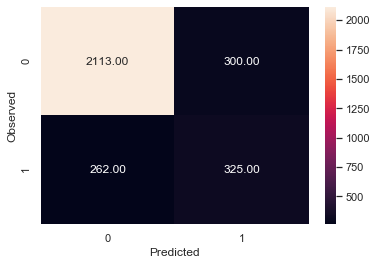

None


In [44]:
# printing the confusion matrix, based on the threshold
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))

In [45]:
# to confirm these values, we can exctract them directly from the model:
results = model.evaluate(X_test2, y_test, verbose=0)
print(model.metrics_names)
print(results)

['loss', 'accuracy', 'recall_6']
[0.6120338057676951, 0.81266665, 0.5536627]


The Accuracy is >0.81 for this last model

In [46]:
# Now, I will change the Threshold and plot hot it influences the scores: 
sensDf = pd.DataFrame(   # create a results table:
    {'Thres':[0],'TAccuracy': [0],'TRecall': [1]})
sensDf = sensDf[['Thres','TAccuracy','TRecall']]
for j in range(1,100):
    y_predict = []
    for val in y_pred:
        y_predict.append(np.where(val>=(j/100),1,0))
    TT=0
    for i in range(0,len(y_predict)):
        if y_predict[i]==y_test[i]:
            TT=TT+1
    Accur=TT/len(y_test)
    tempSensDf = pd.DataFrame({'Thres':[j/100],'TAccuracy': [Accur],'TRecall': [recall_score(y_test,y_predict)]})
    sensDf = pd.concat([sensDf, tempSensDf])  

Text(0, 0.5, 'Red=Accuracy,    Blue=Recall')

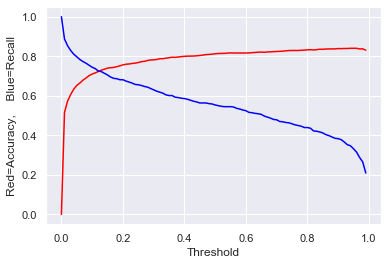

In [47]:
plt.plot(sensDf['Thres'],sensDf['TAccuracy'],'r',sensDf['Thres'],sensDf['TRecall'],'b')
plt.xlabel('Threshold')
plt.ylabel('Red=Accuracy,    Blue=Recall')

In [48]:
#There is a tradeoff point at 0.13
y_pred = model.predict_proba(X_test2, batch_size=2000, verbose=0)
y_predict = []
for val in y_pred:
    y_predict.append(np.where(val>=0.13,1,0))
    TT=0
for i in range(0,len(y_predict)):
    if y_predict[i]==y_test[i]:
        TT=TT+1
Accur=TT/len(y_test)
print("Calculated Accuracy :",Accur)
print("Recall:",recall_score(y_test,y_predict)) # Printing recall from the thereshold of 0.5 

Calculated Accuracy : 0.73
Recall: 0.7223168654173765


This is th highest recall thereshold, but the Accuracy diminishes to .7 (still not so bad)

### Conclusions:
Type of normalization/scaling has a big impact in the behaviour of the model(s), Zscore with untreated outliers can overfit the model. Using MinMax scaling can yield to a model that can generalize better and be usable, for this database. 

The bank can use this model to predict who will exit with an Accuracy between of around 80%
We could apply tunning to improve the model, but if we could get from the bank more features or even make a customer satisfaction survey, these results could improve.
